<h3>Group level sensor domain analysis</h3>

Imports

In [28]:
import os
from os import path as op

import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft

import mne
from mne import (read_evokeds, grand_average)
from mne.stats import permutation_t_test
from mne.viz import plot_evoked_topo
from mne.time_frequency import psd_multitaper

from bad_baby.picks import mismatch_subjects

mne.set_log_level(verbose='WARNING')
%matplotlib inline

In [2]:
def calc_plv(ep, freq_picks=None):
    ep_fft, f, fstep = epochs_fft(ep, freq_picks)
    plv = np.abs(np.mean(ep_fft.get_data() / np.abs(ep_fft.get_data()),
                         axis=0))
    return plv, f


def epochs_fft(ep, freq_picks):
    # from pyfftw.np_fft import fft
    ep_fft = ep.copy()

    if freq_picks is None:
        ep_fft._data = fft(ep.get_data())

        # convert times to frequency
        f = np.arange(len(ep.times), dtype=float) / len(ep.times) * \
            ep.info['sfreq']
        #fstep = f[1] - f[0]
        fmax = f[np.ceil(len(f) / 2.).astype(int)]
        #ep_fft.times = f
        #ep_fft.tmin = 0
        #ep_fft.tmax = f[-1]
        ep_fft.crop(tmin=0, tmax=fmax)  # don't understand this error
        f = ep_fft.times
    else:
        # pick only the frequencies we care about and calculate exactly
        freq_picks = np.array(freq_picks).ravel()
        phasors = np.exp(-2j * np.pi * ep.times[:, np.newaxis] *
                         freq_picks[np.newaxis, :])
        d = (ep.get_data()[..., np.newaxis] *
             phasors[np.newaxis, np.newaxis, ...]).sum(axis=-2)
        """d = []
        for ei in range(len(ep)):
            d += [ep.get_data()[ei].dot(phasors)]
        sd"""
        ep_fft._data = np.array(d)
        ep_fft.times = freq_picks
        f = freq_picks
        fstep = 1
    return ep_fft, f, fstep

Useful parameters

In [7]:
lpf = 48
analysis = 'AM_tone'
conditions = ['tone']
studydir = '/media/ktavabi/ALAYA/data/ilabs/bad_baby/tone/'
fig_dir = op.join(studydir, 'figures')
if not op.isdir(fig_dir):
    os.mkdir(fig_dir)

two_mos = ['bad_208a', 'bad_209a', 'bad_301a', 'bad_921a',
           'bad_923a', 'bad_302a', 'bad_116a', 'bad_122a', 
           'bad_120a', 'bad_124a', 'bad_127a', 'bad_132a', 
           'bad_133a', 'bad_211a', 'bad_222a', 'bad_223a',
           'bad_224a', 'bad_226a', 'bad_228a', 
           'bad_231a', 'bad_232a', 'bad_309a', 'bad_310a', 
           'bad_317a', 'bad_318a', 'bad_319a', 'bad_320a', 
           'bad_117a', 'bad_128a', 'bad_129a', 'bad_130a',
           'bad_131a', 'bad_134a', 'bad_215a', 'bad_218a',
           'bad_220a', 'bad_225a', 'bad_311a', 'bad_312a',
           'bad_314a', 'bad_119a']  

six_mos = ['bad_120b', 'bad_122b', 'bad_208b', 'bad_215b', 
           'bad_223b', 'bad_226b', 'bad_301b', 'bad_304b',
           'bad_310b', 'bad_921b', 'bad_923b', 'bad_925b',
           'bad_116b', 'bad_224b', 'bad_225b', 'bad_117b', 
           'bad_119b', 'bad_127b', 'bad_209b', 'bad_211b',
           'bad_311b', 'bad_309b']


### Field maps of grand averaged evoked data
Note here `mne.grand_average` assumes all eovoked datasets use an identical device to head transformation matrix, but since that is not the case the topological plots are distorted.

##### Two months

In [9]:
evokeds = []
for subj in two_mos:
    evoked_file = op.join(studydir, subj, 'inverse',
                          '%s_%d-sss_eq_%s-ave.fif' % (analysis, lpf,
                                                       subj))
    evoked = read_evokeds(evoked_file, condition=conditions[0], baseline=(None,0))
    evokeds.append(evoked)

two_mos_grndavr = grand_average(evokeds)



N = 41



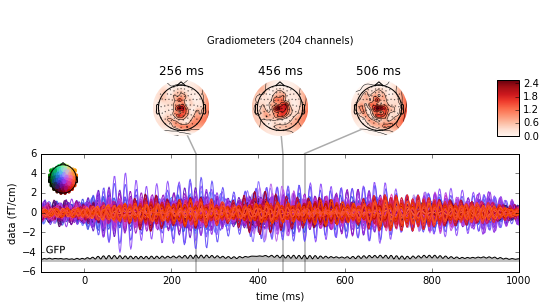

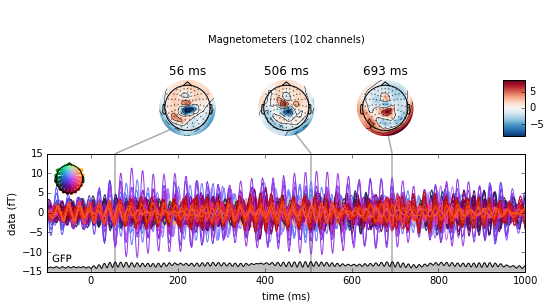

In [13]:
print('\nN = %d\n' % len(two_mos))
hs = two_mos_grndavr.plot_joint(ts_args={'gfp' : True})
for h, ch_type in zip(hs, ['grad', 'mag']):
    h.savefig(op.join(studydir, fig_dir, '%s_%d_%s_N%d-ave.png'
                      % (conditions[0], lpf, ch_type, len(two_mos))), dpi=240, format='png')
peak_latency = two_mos_grndavr.get_peak(ch_type='grad', tmin=0.)[1]
tmin = peak_latency - .025; tmax = peak_latency + .025


##### Six months

In [14]:
evokeds = []
for subj in six_mos:
    evoked_file = op.join(studydir, subj, 'inverse',
                          '%s_%d-sss_eq_%s-ave.fif' % (analysis, lpf,
                                                       subj))
    evoked = read_evokeds(evoked_file, condition=conditions[0], baseline=(None,0))
    evokeds.append(evoked)

six_mos_grndavr = grand_average(evokeds)



N = 22



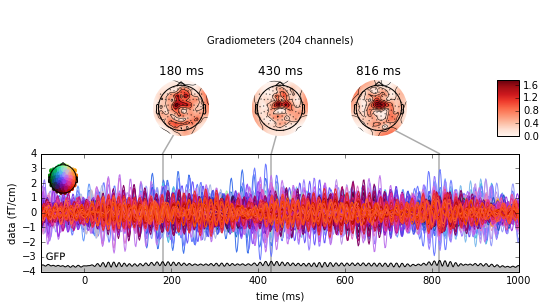

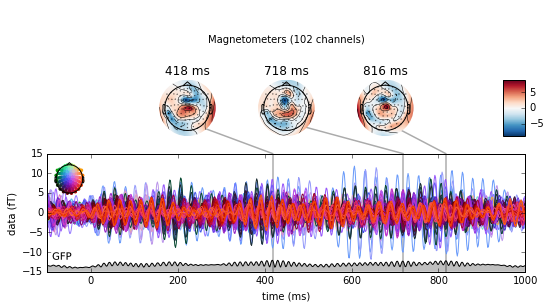

In [15]:
print('\nN = %d\n' % len(six_mos))
hs = six_mos_grndavr.plot_joint(ts_args={'gfp' : True})
for h, ch_type in zip(hs, ['grad', 'mag']):
    h.savefig(op.join(studydir, fig_dir, '%s_%d_%s_N%d-ave.png'
                      % (conditions[0], lpf, ch_type, len(six_mos))), dpi=240, format='png')
peak_latency = six_mos_grndavr.get_peak(ch_type='grad', tmin=0.)[1]
tmin = peak_latency - .025; tmax = peak_latency + .025


### Sesnsor permutation t-test 
For each individual ERF data test if the signal across gradiometers significantly deviates from 0 in the interval 175-250ms post-stimulus onset, i.e., reliability of evoked response.

In [ ]:
for subj in subjects:
    epochs_fname = op.join(studydir, subj, 'epochs/All_%d-sss_%s-epo.fif' % (lpf, subj))
    epochs = mne.read_epochs(epochs_fname)
    good_epochs = epochs.copy()
    good_epochs.drop_bad_epochs()
    good_epochs.apply_baseline((None, 0))
    sensors, pvals, sig_sensors, evoked = permute_sensors(good_epochs, tmin=.175, tmax=.25, 
                                                          n_jobs=12, nperm=100)
    stats_picks = mne.pick_channels(evoked.ch_names, sensors)
    mask = pvals[:, np.newaxis] <= 0.05
    fig = evoked.plot_topomap(ch_type='grad', times=[0], scale=1, 
                              time_format=None, cmap='Reds', vmin=0., vmax=np.max,
                              unit='-log10(p)', cbar_fmt='-%0.1f', mask=mask,
                              size=3, show_names=lambda x: x[0:] + ' ' * 20)
    #fig.savefig(op.join(studydir, subj, 'epochs/All_%d-sss_%s-sens-ttest.png' % (lpf, subj)), format='png')

### Epochs PSD

In [9]:
for subj in subjects:
    epochs_fname = op.join(studydir, subj, 'epochs/All_%d-sss_%s-epo.fif' % (lpf, subj))
    epochs = mne.read_epochs(epochs_fname, preload=True)
    good_epochs = epochs.copy()
    good_epochs.pick_types(meg='grad')
    good_epochs.drop_bad_epochs()
    good_epochs.apply_baseline((None, 0))
    # Let's first check out all channel types by averaging across epochs.
    fig = good_epochs.plot_psd(n_jobs=18, adaptive=True, dB=True)
    fig.savefig(op.join(studydir, subj, 'epochs/All_%d-sss_%s-psd.png' % (lpf, subj)), format='png')
    # Now let's take a look at the spatial distributions of the psd.
    fig = good_epochs.plot_psd_topomap(ch_type='grad', normalize=True, n_jobs=18)
    #fig = fig.savefig(op.join(studydir, subj, 'epochs/All_%d-sss_%s-psd-topo.png' % (lpf, subj)), format='png')


### Phase Locking

two_mos


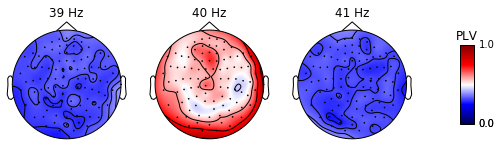

six_mos


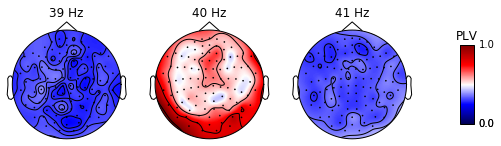

In [31]:
for grp, name in zip([two_mos, six_mos], ['two_mos', 'six_mos']):
    evokeds = []
    for subj in grp:
        evoked_file = op.join(studydir, subj,
                              'inverse',
                              '%s_%d-sss_eq_%s-ave.fif'
                              % (analysis, lpf,subj))
        evoked = read_evokeds(evoked_file,
                              condition=conditions[0],
                              baseline=(None,0))
        evoked.pick_types(meg='grad')
        epochs_fname = op.join(studydir, subj,
                               'epochs/All_%d-sss_%s-epo.fif'
                               % (lpf, subj))
        epochs = mne.read_epochs(epochs_fname, preload=True)
        good_epochs = epochs.copy()
        good_epochs.pick_types(meg='grad')
        good_epochs.drop_bad()
        good_epochs.apply_baseline((None, 0))
        # convert times to frequency
        f = np.arange(len(good_epochs.times),
                      dtype=float) / len(good_epochs.times) * \
                      good_epochs.info['sfreq']
        fmax = f[np.ceil(len(f) / 2.).astype(int)]
        evoked.data, evoked.times = calc_plv(good_epochs,
                                             freq_picks=(39, 40, 41))
        evokeds.append(evoked)
    grndavr_fft = grand_average(evokeds)
    print(name)    
    fig = grndavr_fft.plot_topomap(times=evoked.times, vmin=0, vmax=1, 
                                   scale=4, scale_time=1, unit='PLV',
                                   cmap = 'seismic', res=128, size=2,
                                   time_format='%d Hz')
    fig.savefig(op.join(fig_dir, '%s-%s_%d_N%d-plv.png'
                        % (name, conditions[0], lpf,
                           len(grp))), dpi=240, format='png')
